# Swithing Kalman filter parameter tuning using synthetic anomalies
This tutorial example presents how to calibrate the hyperparameters of the SSM & LSTM network, as well as the hyperparameters of a switching Kalman filter (SKF) using synthetic anomalies and the external Ray Tune library. The example involves the detection of anomalies that take the form of change points. The model relies on the SKF for estimating the probability of the local trend regime versus a local acceleration regime, whereas a high probability for the later indicates the presence of a change point in a time series.

The calibration of the LSTM neural network relies on the raw traning set that is deemed to be stationnary and the SKF hyperparameters are estimated using synthetic anomalies that are added on the raw traning set. 

In this example, we use a simple sine-like signal onto which we add a synthetic regime change marking the time series swithcing from a stationnary regime to a trend-statinnary one.

### Import libraries
Import the various libraries that will be employed in this example.

In [1]:
import copy
from pathlib import Path
project_root = Path.cwd().resolve().parents[1]
import ray
ray.shutdown()
ray.init(
    runtime_env={
        "working_dir": str(project_root),
        "excludes": [".git"]
    }
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pytagi import Normalizer
import pytagi.metric as metric


2025-12-16 13:19:19,997	INFO worker.py:1951 -- Started a local Ray instance.
2025-12-16 13:19:20,094	INFO packaging.py:588 -- Creating a file package for local module '/Users/vuongdai/GitHub/canari'.
2025-12-16 13:19:20,119	INFO packaging.py:380 -- Pushing file package 'gcs://_ray_pkg_7fb4b87ff02d2a62.zip' (3.05MiB) to Ray cluster...
2025-12-16 13:19:20,127	INFO packaging.py:393 -- Successfully pushed file package 'gcs://_ray_pkg_7fb4b87ff02d2a62.zip'.


### Import from Canari
From Canari, we need to import several classes that will be reused in this example. Notably, we need to import the components that will be used to build the model; In terms of baseline, we the SKF will build two competing models using respectively the `LocalTrend` and `LocalAcceleration` components. The recurrent pattern is modelled using a `LstmNetwork` and the residual is modelled by a `WhiteNoise` compoment.

In [2]:
from canari import (
    DataProcess,
    Model,
    SKF,
    Optimizer,
    plot_data,
    plot_prediction,
    plot_states,
    plot_skf_states,
)
from canari.component import LocalTrend, LocalAcceleration, LstmNetwork, WhiteNoise

### Read data
The raw `.csv` data is saved in a dataframe using the Pandas external library.

In [3]:
project_root = Path.cwd().resolve().parents[1]
data_file = str(project_root / "data/toy_time_series/sine.csv")
df = pd.read_csv(data_file, skiprows=1, delimiter=",", header=None)
# Add synthetic anomaly to data
trend = np.linspace(0, 0, num=len(df))
time_anomaly = 120
new_trend = np.linspace(0, 1, num=len(df) - time_anomaly)
trend[time_anomaly:] = trend[time_anomaly:] + new_trend
df = df.add(trend, axis=0)
#
data_file_time = str(project_root / "data/toy_time_series/sine_datetime.csv")
time_index = pd.read_csv(data_file_time, skiprows=1, delimiter=",", header=None)
time_index = pd.to_datetime(time_index[0])
df.index = time_index
df.index.name = "time"
df.columns = ["values"]

### Data preprocess
In terms of pre-processsing, we want to add the _hour-of-the-day_ as time-covariate for the LSTM network. Moreover we define here our choice of using the first 40% of the raw time series for trainig and the following 10% for the validaiton set. The remaining last 50% are the implicitely defined as the test set. 

In [4]:
output_col = [0]
data_processor = DataProcess(
    data=df,
    time_covariates=["hour_of_day"],
    train_split=0.4,
    validation_split=0.1,
    output_col=output_col,
)
train_data, validation_data, test_data, all_data = data_processor.get_splits()
data_processor.data.head()

,values,hour_of_day
time,,
2000-01-03 00:00:00,0.00,0
2000-01-03 01:00:00,-0.26,1
2000-01-03 02:00:00,-0.50,2
2000-01-03 03:00:00,-0.71,3
2000-01-03 04:00:00,-0.87,4


### A. Optimize the model hyperparameters
This section presents how Canari relies on the Ray Tune library in order to optimize the hyperparameters for the SSM, the LSTM, and the SKF.

#### A.1. Parameter space
First, we need to define which hyperparameters will be optimized and for each of them what is the range of values to be searched. In this example, we search for the optimal look-back window length between 10 and 30 time steps, and the residual component's standard deviation between 0.001 and 0.2. 

In [5]:
param_space = {
    "look_back_len": [10, 30],
    "sigma_v": [1e-3, 2e-1],
    "std_transition_error": [1e-6, 1e-4],
    "norm_to_abnorm_prob": [1e-6, 1e-4],
}

#### A.2. Model as a function of parameters
We need to create a function that makes our model depends on the parameters to be search over.

In [ ]:
def model_with_parameters(param):
    local_trend = LocalTrend()
    pattern = LstmNetwork(
            look_back_len=param["look_back_len"],
            num_features=2,
            num_layer=1,
            infer_len=24 * 3,
            num_hidden_unit=50,
            manual_seed=1,
        )
    residual = WhiteNoise(std_error=param["sigma_v"])
    model = Model(local_trend, pattern, residual)
    model.auto_initialize_baseline_states(train_data["y"][0:24])

    # Training
    num_epoch = 50
    for epoch in range(num_epoch):
        (mu_validation_preds, std_validation_preds, states) = model.lstm_train(
            train_data=train_data,
            validation_data=validation_data,
        )

        # Unstandardize the predictions
        mu_validation_preds_unnorm = Normalizer.unstandardize(
            mu_validation_preds,
            data_processor.scale_const_mean[data_processor.output_col],
            data_processor.scale_const_std[data_processor.output_col],
        )

        std_validation_preds_unnorm = Normalizer.unstandardize_std(
            std_validation_preds,
            data_processor.scale_const_std[data_processor.output_col],
        )

        validation_obs = data_processor.get_data("validation").flatten()
        validation_log_lik = metric.log_likelihood(
            prediction=mu_validation_preds_unnorm,
            observation=validation_obs,
            std=std_validation_preds_unnorm,
        )

        model.early_stopping(
            evaluate_metric=-validation_log_lik,
            current_epoch=epoch,
            max_epoch=num_epoch,
        )
        model.metric_optim = model.early_stop_metric

        if model.stop_training:
            break
    
    #### Define SKF model with parameters #########
    abnorm_model = Model(
        LocalAcceleration(),
        LstmNetwork(),
        WhiteNoise(),
    )
    skf = SKF(
        norm_model=model,
        abnorm_model=abnorm_model,
        std_transition_error=param["std_transition_error"],
        norm_to_abnorm_prob=param["norm_to_abnorm_prob"],
    )
    skf.save_initial_states()

    skf.filter(data=all_data)
    log_lik_all = np.nanmean(skf.ll_history)
    skf.metric_optim = -log_lik_all  # <- This is the metric used for optimization

    skf.load_initial_states()

    return skf

#### A.3. Define optimizer
We instantiate and run the optimizer for our example. The metric used for optimization is `skf.metric_optim`.
The results is a set of optimal hyperparameters for our model. 

In [7]:
model_optimizer = Optimizer(
    model=model_with_parameters,
    param=param_space,
    num_optimization_trial=50,
    mode="min",
)
model_optimizer.optimize()

#  1/50 - Metric: -0.757 - Parameter: {'look_back_len': 17, 'sigma_v': 0.03774793401758054, 'std_transition_error': 9.751426036235058e-05, 'norm_to_abnorm_prob': 8.182561593929109e-05}
#  2/50 - Metric: 0.523 - Parameter: {'look_back_len': 16, 'sigma_v': 0.14826704323764373, 'std_transition_error': 3.2896251544842754e-05, 'norm_to_abnorm_prob': 7.710580600260074e-05}
#  3/50 - Metric: -0.450 - Parameter: {'look_back_len': 24, 'sigma_v': 0.08367815774449992, 'std_transition_error': 7.725482172525176e-05, 'norm_to_abnorm_prob': 8.3998886739675e-05}
#  4/50 - Metric: -0.407 - Parameter: {'look_back_len': 22, 'sigma_v': 0.12661772491710435, 'std_transition_error': 7.875125195818762e-05, 'norm_to_abnorm_prob': 4.43260951499675e-05}
#  5/50 - Metric: 2.600 - Parameter: {'look_back_len': 29, 'sigma_v': 0.1113837231288187, 'std_transition_error': 1.1559207262454414e-05, 'norm_to_abnorm_prob': 9.522542731191502e-06}
#  6/50 - Metric: -0.069 - Parameter: {'look_back_len': 24, 'sigma_v': 0.085854

2025-12-16 13:21:50,876	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/vuongdai/ray_results/objective_2025-12-16_13-19-23' in 0.0152s.


# 50/50 - Metric: 4.693 - Parameter: {'look_back_len': 11, 'sigma_v': 0.11438967872096645, 'std_transition_error': 5.278148995176988e-06, 'norm_to_abnorm_prob': 7.550217980822061e-05}
-----
Optimal parameters at trial #46. Best metric: -1.2170. Best print metric: None. Best param: {'look_back_len': 10, 'sigma_v': 0.0056459826835485605, 'std_transition_error': 9.779000020839657e-05, 'norm_to_abnorm_prob': 5.6214454739391054e-05}.
-----


#### A.4 Get optimal model
We then get the best model parameters and model.

In [8]:
param_optim = model_optimizer.get_best_param()
skf_optim = model_with_parameters(param_optim)

#### A.5 Anomaly detection
We perform the changepoint detection by using the SKF filter or smoother. The filter represents the results obtained during online data processing and the smoother those obtained during offline processing.

In [9]:
filter_marginal_abnorm_prob, states = skf_optim.filter(data=all_data)
smooth_marginal_abnorm_prob, states = skf_optim.smoother()

#### A.6 Hidden states and proability of anomalies
We represent the time-series decomposition visually where the raw data is overlaid with the baseline hidden state represented by the level. The rate of change of the baseline is characterized by the trend and acceleration hidden states. The recurrent pattern is captured by the LSTM neural network. The posterior estimate for the residuals are displayed for the white noise component. Finaly, the probability of anomaly obtained from the SKF indicated the possible location of change point from a stationnary regime to a trend-stationnary one.

Note that the results now extend into the test set.

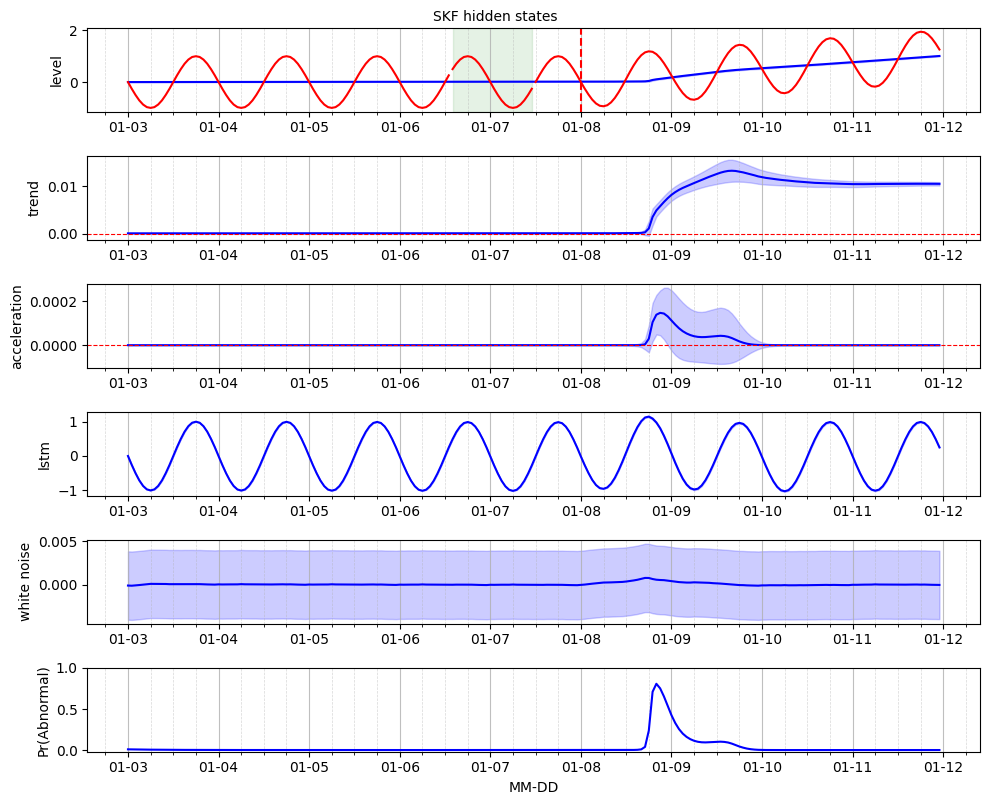

In [10]:
fig, ax = plot_skf_states(
    data_processor=data_processor,
    states=states,
    model_prob=filter_marginal_abnorm_prob,
)
ax[0].axvline(
    x=data_processor.data.index[time_anomaly],
    color="r",
    linestyle="--",
)
fig.suptitle("SKF hidden states", fontsize=10, y=1)
ax[-1].set_xlabel("MM-DD")
plt.show()